In [188]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
from sklearn.decomposition import PCA
import tkinter as tk
from tkinter import filedialog

from metrics import Metric,SSIM_function,PSNR_function,Qabf_function,Nabf_function,MI_function,MSE_function,SCD_function,MS_SSIM_function


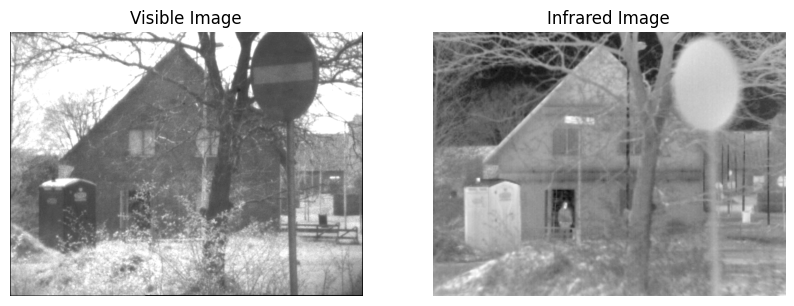

In [189]:
# Load visible and infrared images
root = tk.Tk()
root.withdraw()  # Hide the root window

vi_image_path = filedialog.askopenfilename(initialdir="TNO_Image_Fusion_Dataset",title="Select Visible Image")
ir_image_path = filedialog.askopenfilename(initialdir="TNO_Image_Fusion_Dataset",title="Select Infrared Image")

vi_image = cv2.imread(vi_image_path, cv2.IMREAD_GRAYSCALE)
ir_image = cv2.imread(ir_image_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(vi_image, cmap='gray')
plt.title('Visible Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ir_image, cmap='gray')
plt.title('Infrared Image')
plt.axis('off')

plt.show()

In [190]:
def evaluate_fusion_performance(method, image_vi, image_ir, fused_image):
    import warnings
    warnings.filterwarnings('ignore')
    # Convert images to float32
    image_vi = image_vi.astype(np.float32)
    image_ir = image_ir.astype(np.float32)
    fused_image = fused_image.astype(np.float32)
    
    # SSIM
    ssim_score = SSIM_function(image_vi, image_ir,fused_image)
    print(f"{method} Method SSIM is {ssim_score:.4f}")
    
    # PSNR
    psnr_score = PSNR_function(image_vi, image_ir,fused_image)
    print(f"{method} Method PSNR is {pnr_score:.4f}")
    # Quality Assessment Based Fusion
    psnr_score = Qabf_function(image_vi, image_ir,fused_image)
    print(f"{method} Method QABF is {psnr_score:.4f}")
    #Normalized Absolute Blurring Factor    
    psnr_score = Nabf_function(image_vi, image_ir,fused_image)
    print(f"{method} Method NABF is {psnr_score:.4f}")
    
    # NRMSE
    nrmse_score = MSE_function(image_vi, image_ir,fused_image)
    print(f"{method} Method MSE is {nrmse_score:.4f}")
    
    # Structure Consistency Based Metric
    hausdorff_score = SCD_function(image_vi, image_ir,fused_image)
    print(f"{method} Method SCD is {hausdorff_score:.4f}")
    
    # MSE (Mean Squared Error)
    mse_score = MS_SSIM_function(image_vi, image_ir,fused_image)
    print(f"{method} Method MS SSIM is {mse_score:.4f}")

In [191]:
def swt_fusion(vi_image, ir_image, level=1):
    # Ensure input images have the same shape
    min_shape = min(vi_image.shape, ir_image.shape)
    vi_image = vi_image[:min_shape[0], :min_shape[1]]
    ir_image = ir_image[:min_shape[0], :min_shape[1]]

    # Decompose visible and infrared images using SWT
    vis_coeffs = pywt.swt2(vi_image, 'db4', level=level)
    ir_coeffs = pywt.swt2(ir_image, 'db4', level=level)

    # Perform PCA-based fusion rule
    fused_coeffs = []
    for (vis_appro, vis_detail), (ir_appro, ir_detail) in zip(vis_coeffs, ir_coeffs):
        fused_detail = []
        for i in range(len(vis_detail)):
            # Compute PCA
            pca = PCA(n_components=1)
            vis_pca = pca.fit_transform(vis_detail[i].reshape(-1, 1))
            ir_pca = pca.transform(ir_detail[i].reshape(-1, 1))

            # Fuse using maximum rule
            fused_pca = np.maximum(vis_pca, ir_pca)

            # Reshape back to original shape
            fused_pca = fused_pca.reshape(vis_detail[i].shape)
            fused_detail.append(fused_pca)

        fused_coeffs.append((vis_appro, tuple(fused_detail)))

    # Reconstruct fused image from coefficients
    fused_image = pywt.iswt2(fused_coeffs, 'db4')

    # Normalize pixel values to 0-255 range
    fused_image = cv2.normalize(fused_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return fused_image


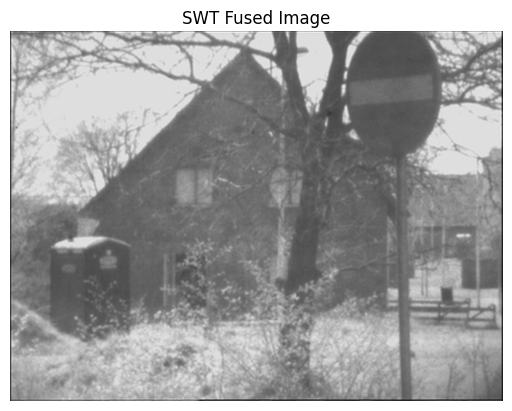

torch.Size([1, 1, 1, 576, 768]) torch.Size([1, 1, 1, 576, 768])
torch.Size([1, 1, 1, 576, 768]) torch.Size([1, 1, 1, 576, 768])
SWT Method SSIM is 0.3576
SWT Method PSNR is 61.9066
SWT Method QABF is 0.4312
SWT Method NABF is 0.0085
SWT Method MSE is 0.0419
SWT Method SCD is 1.2943
SWT Method MS SSIM is 0.4703


In [192]:
fused_image = swt_fusion(vi_image, ir_image)

plt.figure()
plt.imshow(fused_image, cmap='gray')
plt.title('SWT Fused Image')
plt.axis('off')
plt.show()
evaluate_fusion_performance('SWT', vi_image, ir_image, fused_image)

In [193]:
def laplacian_pyramid_blending(vi_image, ir_image, levels=3):
    # Gaussian pyramid for visible image
    vi_pyramid = [vi_image.astype(np.float32)]
    for _ in range(levels - 1):
        vi_image = cv2.pyrDown(vi_image)
        vi_pyramid.append(vi_image.astype(np.float32))

    # Gaussian pyramid for infrared image
    ir_pyramid = [ir_image.astype(np.float32)]
    for _ in range(levels - 1):
        ir_image = cv2.pyrDown(ir_image)
        ir_pyramid.append(ir_image.astype(np.float32))

    # Laplacian pyramid for visible image
    vi_laplacian = [vi_pyramid[levels - 1]]
    for i in range(levels - 2, -1, -1):
        vi_expanded = cv2.pyrUp(vi_pyramid[i + 1], dstsize=(vi_pyramid[i].shape[1], vi_pyramid[i].shape[0]))
        vi_laplacian.append(vi_pyramid[i] - vi_expanded)

    # Laplacian pyramid for infrared image
    ir_laplacian = [ir_pyramid[levels - 1]]
    for i in range(levels - 2, -1, -1):
        ir_expanded = cv2.pyrUp(ir_pyramid[i + 1], dstsize=(ir_pyramid[i].shape[1], ir_pyramid[i].shape[0]))
        ir_laplacian.append(ir_pyramid[i] - ir_expanded)

    # Blend the Laplacian pyramids
    blended_laplacian = []
    for vi_layer, ir_layer in zip(vi_laplacian, ir_laplacian):
        blended_laplacian.append(vi_layer * 0.5 + ir_layer * 0.5)

    # Reconstruct the fused image
    fused_image = blended_laplacian[0]
    for i in range(1, levels):
        fused_image = cv2.pyrUp(fused_image, dstsize=(blended_laplacian[i].shape[1], blended_laplacian[i].shape[0]))
        fused_image += blended_laplacian[i]

    # Normalize pixel values to 0-255 range
    fused_image = cv2.normalize(fused_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    fig, axs = plt.subplots(levels, 4, figsize=(12, 12))

    # Display each level of the Laplacian and Gaussian pyramids
    for i in range(levels):
        axs[i, 0].imshow(vi_pyramid[i], cmap='gray')
        axs[i, 0].set_title(f'Visible Gaussian Level {i+1}')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(ir_pyramid[i], cmap='gray')
        axs[i, 1].set_title(f'Infrared Gaussian Level {i+1}')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(vi_laplacian[i], cmap='gray')
        axs[i, 2].set_title(f'Visible Laplacian Level {i+1}')
        axs[i, 2].axis('off')

        axs[i, 3].imshow(ir_laplacian[i], cmap='gray')
        axs[i, 3].set_title(f'Infrared Laplacian Level {i+1}')
        axs[i, 3].axis('off')

    plt.tight_layout()
    plt.show()
    
    return fused_image

In [194]:
def multi_scale_retinex(image, sigma_list=[15, 80, 250]):
    retinex = np.zeros_like(image, dtype=np.float32)
    for sigma in sigma_list:
        gaussian = cv2.GaussianBlur(image, (0, 0), sigma)
        retinex = np.maximum(retinex, np.log(image + 1) - np.log(gaussian + 1))
    return retinex

def multi_scale_retinex_fusion(vi_image, ir_image):
    # Convert images to float32 for processing
    vi_image = vi_image.astype(np.float32)
    ir_image = ir_image.astype(np.float32)

    # Perform multi-scale retinex enhancement
    vi_retinex = multi_scale_retinex(vi_image)
    ir_retinex = multi_scale_retinex(ir_image)

    # Fuse retinex-enhanced images using weighted averaging
    fused_retinex = 0.5 * (vi_retinex + ir_retinex)

    # Normalize pixel values to 0-255 range
    fused_image = cv2.normalize(fused_retinex, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return fused_image


In [195]:
def hybrid_fusion(vi_image, ir_image, levels=3):
    # Perform Laplacian pyramid blending
    global laplacian_fused,retinex_fused
    laplacian_fused = laplacian_pyramid_blending(vi_image, ir_image, levels)
    
    # Perform multi-scale retinex fusion
    retinex_fused = multi_scale_retinex_fusion(vi_image, ir_image)
    
    # Combine fused images using weighted averaging
    hybrid_fused = 0.5 * (laplacian_fused.astype(np.float32) + retinex_fused.astype(np.float32))

    # Normalize pixel values to 0-255 range
    hybrid_fused = cv2.normalize(hybrid_fused, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return hybrid_fused

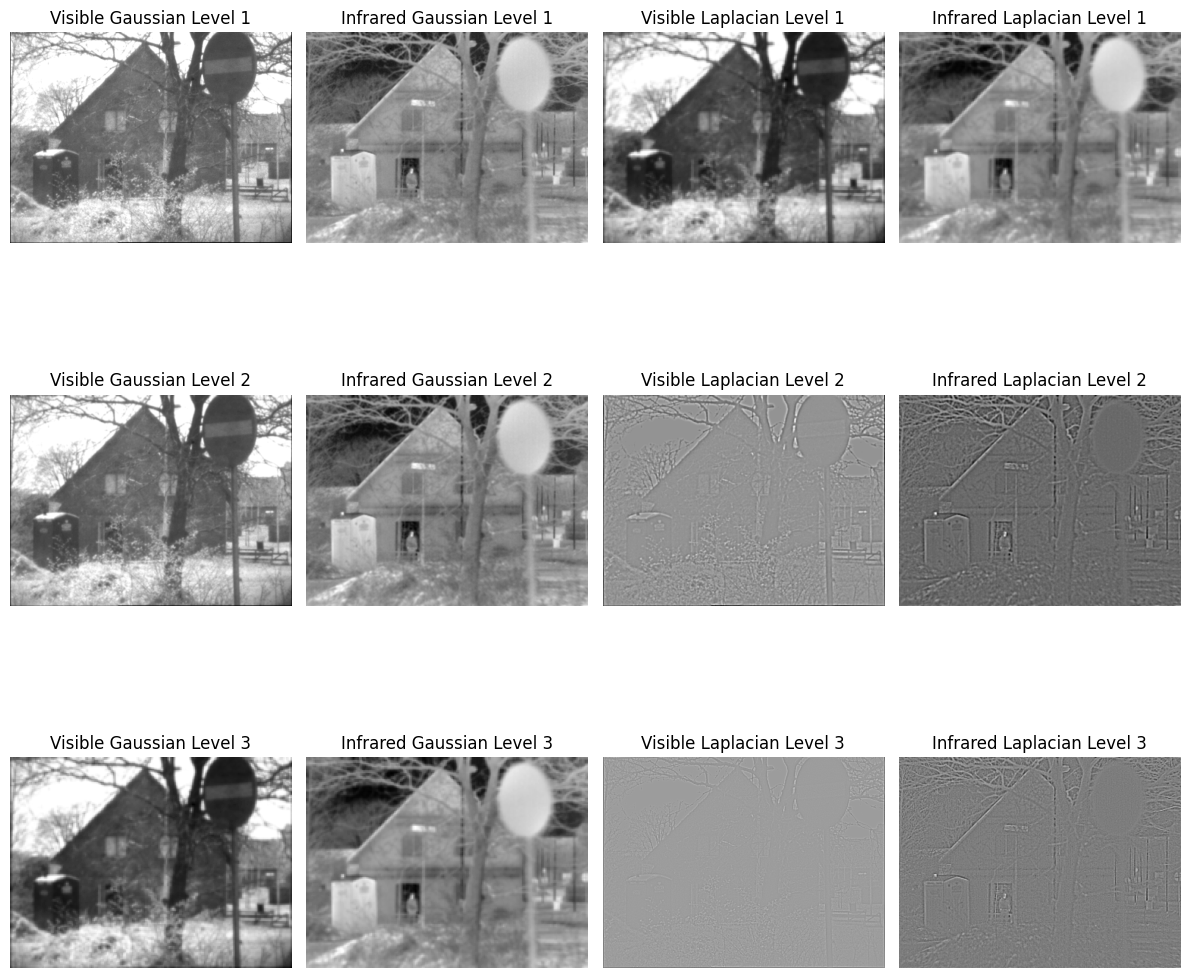

In [196]:
fused_image = hybrid_fusion(vi_image, ir_image)

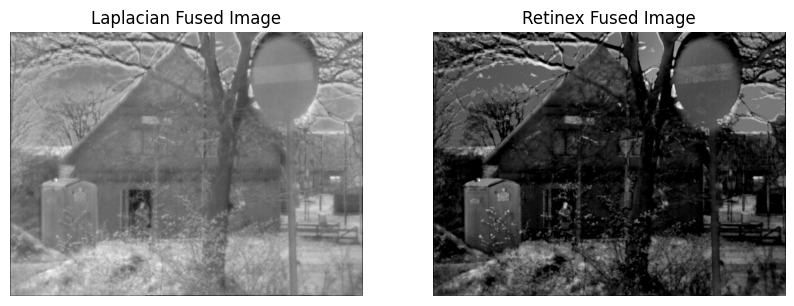

In [197]:
global laplacian_fused,retinex_fused
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(laplacian_fused, cmap='gray')
plt.title('Laplacian Fused Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(retinex_fused, cmap='gray')
plt.title('Retinex Fused Image')
plt.axis('off')

plt.show()

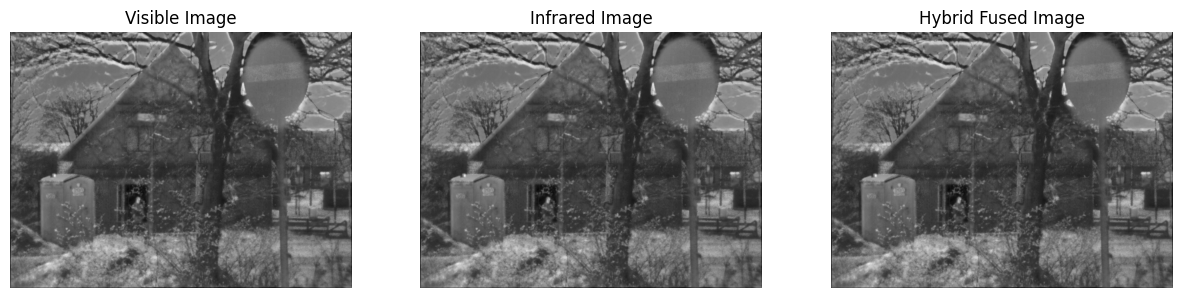

In [211]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 3, 1)
plt.imshow(vi_image, cmap='gray')
plt.title('Visible Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(ir_image, cmap='gray')
plt.title('Infrared Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(fused_image, cmap='gray')
plt.title('Hybrid Fused Image')
plt.axis('off')

plt.show()
ir_image=fused_image

In [212]:
evaluate_fusion_performance('Hybrid Fusion', ir_image, vi_image, fused_image)

torch.Size([1, 1, 1, 576, 768]) torch.Size([1, 1, 1, 576, 768])
torch.Size([1, 1, 1, 576, 768]) torch.Size([1, 1, 1, 576, 768])
Hybrid Fusion Method SSIM is 1.0000
Hybrid Fusion Method PSNR is inf
Hybrid Fusion Method QABF is 0.9753
Hybrid Fusion Method NABF is 0.0000
Hybrid Fusion Method MSE is 0.0000
Hybrid Fusion Method SCD is nan
Hybrid Fusion Method MS SSIM is 1.0000
